In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
from torchsummary import summary
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mpl.style.use('dark_background')

In [ ]:
#import the dataset

data_folder = '~/data/FMNIST'

fmnist = datasets.FashionMNIST(data_folder, download = True, train = True )

tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
ix = np.random.randint(len(tr_images))

plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

## Building a CNN

In [ ]:
#Build a toy dataset

X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],
                          [5,6,7,8],[1,3,4,5]]],
                        [[[-1,2,3,-4],[2,-3,4,5],
                          [-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()
X_train /= 8 #we are scaling the input dataset so that it has a range between -1 to +1 by dividing the input data by the maximum input value; that is, 8
y_train = torch.tensor([0,1]).to(device).float()

> ```Note that PyTorch expects inputs to be of the shape N x C x H x W, where N is the number (batch size) of images, C is the number of
channels, H is the height, and W is the width of the image```

In [ ]:
#define the model and the components to use
def get_model():
    model = nn.Sequential( nn.Conv2d(1, 1, kernel_size=3),
                         nn.MaxPool2d(2),
                         nn.ReLU(),
                         nn.Flatten(),
                         nn.Linear(1,1),
                         nn.Sigmoid(),).to(device)
    
    loss_fn = nn.BCELoss()#BCE = Binary CrossEntropy due to the output being just 0 and 1
    optimizer = Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [ ]:
model, loss_fn, optimizer = get_model()

summary(model, X_train)

In [ ]:
#get the model and it's components and define the trainig process

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0), y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
#Define the training DataLoader by specifying the dataset using the TensorDataset method and then loading it using DataLoader:

trn_dl = DataLoader(TensorDataset(X_train, y_train)) #load the tensonrs and load them as a dataset

In [ ]:
#train for 2000 epochs

for epoch in range(2000):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

In [ ]:
#Perform a forward pass on top of the first data point

model(X_train[:1])

## testing a CNN on the fashion MNIST dataset

In [ ]:
#define the class for the dataset and it's preprocessing
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [ ]:
trn_dl = get_data()

In [ ]:
def get_model():
    model = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3), #1 biases. 1 input from before
                         nn.MaxPool2d(2),
                         nn.ReLU(),
                         nn.Conv2d(64, 128, kernel_size = 3),
                         nn.MaxPool2d(2),
                         nn.ReLU(),
                         nn.Flatten(),
                         nn.Linear(3200, 256),
                         nn.ReLU(),
                         nn.Linear(256, 10)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer


In [ ]:
#summary the model

model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28))

In [ ]:
#define the training process
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0), y ) #squeeze para volver en 1d ( o de 3d a 2d)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
#trn_dl = DataLoader(TensorDataset(X_train, y_train))

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
losses = []
accuracies = []

In [ ]:
# #train loop
# for epoch in range(10):
#     epoch_losses, epoch_accuracies = [], []
#     for ix, batch in enumerate(trn_dl):
#         x, y = batch
#         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
#         epoch_losses.append(batch_loss)
#     epoch_loss = np.array(epoch_losses).mean()
#     for ix, batch in enumerate(iter(trn_dl)):
#         x, y = batch
#         is_correct = accuracy(x, y, model)
#         epoch_accuracies.extend(is_correct)
#     epoch_accuracy = np.mean(epoch_accuracies)
#     losses.append(epoch_loss)
#     accuracies.append(epoch_accuracy)

## Data Augmentation

In [ ]:
ix = np.random.randint(len(tr_images))
plt.imshow(tr_images[ix], cmap = 'gray')
plt.title(fmnist.classes[tr_targets[ix]])

In [ ]:
from imgaug import augmenters as iaa

In [ ]:
aug = iaa.Affine(scale=2)

# Some of the important parameters in the Affine method are as follows:
# --- scale specifies the amount of zoom that is to be done for the image
# --- translate_percent specifies the amount of translation as a percentage of the image's height and width
# --- translate_px specifies the amount of translation as an absolute number of pixels
# --- rotate specifies the amount of rotation that is to be done on the image
# --- shear specifies the amount of rotation that is to be done on part of the image

In [ ]:
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()))
plt.title('Scaled image')

In [ ]:
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()))
plt.title('Translated image by 10 pixels')

In [ ]:
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()))

In [ ]:
#The problem with the previous augmentation is that we lose parts of the image that are important (like 80% of the tennis on the rotate Affine function)
#for avoiding that but conserving the augmentation we include the parameter 'fit_output'

plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0])
plt.title('original')

aug = iaa.Affine(rotate= 30,   fit_output= True) #<----here
plt.subplot(162)
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()))
plt.title('Changed') 


In [ ]:
# Note that when the size of the augmented image increases (for example, when the
# image is rotated and there is more to the background), we need to figure out how the new pixels that are not part of the
# original image should be filled in.

In [ ]:
#The cval parameter solves this issue. It specifies the pixel value of the new pixels that are created when fit_output is True
aug = iaa.Affine(rotate=30, fit_output=True, cval=255)
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()), cmap= 'gray')

In [ ]:
#changing brightness

#there are two ways: multiply and Linearcontrast

aug = iaa.Multiply(0.5) #multiplies each pixel value by the value that we specify.

plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()), cmap = 'gray', vmin = 0, vmax = 255) #vmin and vmax to see the actual change

In [ ]:
#Linearcontrast adjusts each pixel value based on a formula

aug = iaa.LinearContrast(0.5)
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()), cmap='gray', vmin = 0, vmax = 255)


In [ ]:
#Blur
aug = iaa.GaussianBlur(sigma=1)#the greater the sigm value, the more blur
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
#Adding noise

#It can be done with Dropout and SaltandPepper functions

plt.figure(figsize=(10,10))
plt.subplot(121)
aug = iaa.Dropout(p=0.2) #Drops pixels
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()), cmap='gray', vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')

plt.subplot(122)
aug = iaa.SaltAndPepper(0.2) #adds random pixels. Looks like pouring salt and pepper
plt.imshow(aug.augment_image(tr_images[0].cpu().detach().numpy()), cmap='gray', \
 vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

### Perfoming sequence of augmentations

In [ ]:
seq = iaa.Sequential([
    iaa.Dropout(p=0.2),
    iaa.Affine(rotate= (-30,30))
],random_order=True)

In [ ]:
plt.imshow(seq.augment_image(tr_images[0].cpu().detach().numpy()), cmap='gray', vmin = 0, vmax = 255)
plt.title('Image augmented using a \nrandom order of the two augmentations')


### Augment batches of images

In [ ]:
# in our FMNIST class we have to add a function that takes batches of data as inputs
class FMNISTDataset(Dataset):
    
    def __init__(self, x, y, aug= None):
        self.x, self.y, = x, y
        self.aug = aug
        
    def __getitem__(self, ix):
        x, y = self.x[ix], selfy[ix]
        return x, y
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch): #Specify that augmentation must be done if the augmentation object is provided.
        ims, classes = list(zip(*batch))
        if self.aug: 
            ims = self.aug.augment_images(images=ims)
            ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
            classes = torch.tensor(classes).to(device)
            return ims, classes

In [ ]:
# From now on, to leverage the collate_fn method, we'll use a new 
# argument while creating the DataLoader

train = FMNISTDataset(tr_images, tr_targets, aug=aug)

trn_dl = DataLoader(train, batch_size=64,     collate_fn=train.collate_fn,   shuffle=True)

#Finally, we train the model, as we have been training it so far. B

## Building a CNN for classifying real-world images (cats and dogs)

In [1]:
import numpy as np
import pandas as pd 
from glob import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, models, datasets
from random import shuffle, seed; seed(10);
from PIL import Image
from torchsummary import summary
from torch import optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [4]:
#load the data
train_data_dir = '/Data Science projects/cats_and_dogs/train'
test_data_dir = '/Data Science projects/cats_and_dogs/test'

In [5]:
# 1. Build a class that fetches data from the preceding folders. Then, based on the directory the image corresponds to, provide a label of 1 for "dog"
# images and a label of 0 for "cat" images

# 2. ensure that the fetched image has been normalized to a scale between 0 and 1 and permuteit so that channels are provided first (as PyTorch models expect to have
# channels specified first

class cats_dogs(Dataset):
    def __init__(self,folder):
        #get the paths
        cats = glob(folder+'/*.jpg')
        dogs = glob(folder+'/*.jpg')
        self.fpaths = cats + dogs #concatenate the file paths onto one list
        
        #Get random images and assign 1 to dogs
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
        
    def __len__(self):
        return len(self.fpaths)
    #get the image, resize it and permute it so the channels goes firts. REMEMBER, PYTORCH NEED THE CHANNELS FIRST!
    def __getitem__(self, ix): 
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1]) 
        im = cv2.resize(im, (224,224))
        #normalizar la imagen y cambio del orden del channel(2), height(0), width(1) (recordar ponerlo en gpu y float)
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)


In [6]:
# see if it works
data = cats_dogs(test_data_dir)
im, label = data[200]

tensor([0.], device='cuda:0')


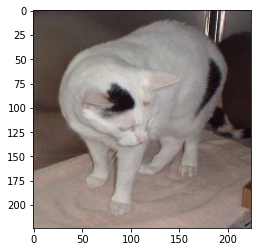

In [7]:
plt.imshow(im.permute(1,2,0).cpu()) #changing the images back to H*W*C so matplotlib can see them
print(label)

In [8]:
#define the model

def conv_layer(ni, no, kernel_size, stride=1): #we define a convolutional layer to be used on the final model.
                                            #Sequential was used to create the sequence of a conv2d layer. We can do this many times inside various other sequentials
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

#In the preceding code, we are taking the number of input channels (ni), number of output channels (no), kernel_size, and the stride
#of filters as input for the conv_layer function

In [9]:
def get_model():
    model = nn.Sequential(conv_layer(3, 64, 3), #3 input since is three channels
                          conv_layer(64, 512, 3),
                          conv_layer(512, 512, 3),
                          conv_layer(512, 512, 3),
                          #conv_layer(512, 512, 3),
                          #conv_layer(512, 512, 3),
                          nn.Flatten(),
                          nn.Linear(512, 1),
                          nn.Sigmoid()
                          ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [10]:
#summarize the model

model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 3, 224, 224))

C:\Users\MSI\anaconda3\envs\tf-latest\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [11]:
#Create the get_data function

In [12]:
def get_data():
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size = 32, shuffle= True, drop_last=True)
    
    vals = cats_dogs(test_data_dir)
    val_dl = DataLoader(vals, batch_size = 32, shuffle=True, drop_last= True)
    
    return trn_dl, val_dl

# In the preceding code, we are ignoring the last batch of data by specifying that drop_last = True. We're doing this because the last batch might not
# be the same size as the other batches (due the amount of data and divided by 32 it might not get a 32 batch but a 29 and that would give an error)

In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [14]:
#define accuracy and validation loss

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [15]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [16]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    #Loss train
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    #Accuracy train
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
 #accuracy val
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)


RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 6.00 GiB total capacity; 4.72 GiB already allocated; 0 bytes free; 4.75 GiB reserved in total by PyTorch)

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

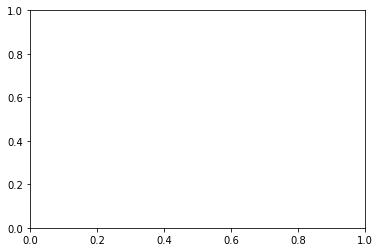

In [17]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()